# Empirical Comparison of Machine Learning Classifiers

This notebook compares Logistic Regression, SVM, and Random Forest classifiers on three datasets: Spambase, Adult, and Mushroom

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

First I'm going to set up my parameters. I'll be using 3 train/test splits (20%/80%, 50%/50%, and 80%/20%) to evaluate how classifier performance changes with varying amounts of training data. Each experiment will be run 3 times and results are averaged to ensure reliability. I'll be using a 3 fold cross validation to balance speed and reliability.

In [2]:
#  parameters
partitions = [
    (0.2, 0.8),
    (0.5, 0.5),
    (0.8, 0.2),
]

num_trials = 3
CV_folds = 3

def most_common_params(series):
    return series.mode().iloc[0]

## Loading Datasets

Next, I need to load in the datasets that I'll be using. I decided to use Spambase, Adult, and Mushroom to run my classifiers on.

### Spambase

In [3]:
def load_spambase():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
    
    column_names = [
        'word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
        'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet',
        'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will',
        'word_freq_people', 'word_freq_report', 'word_freq_addresses',
        'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you',
        'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
        'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
        'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
        'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
        'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
        'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
        'word_freq_original', 'word_freq_project', 'word_freq_re',
        'word_freq_edu', 'word_freq_table', 'word_freq_conference',
        'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$',
        'char_freq_#', 'capital_run_length_average',
        'capital_run_length_longest', 'capital_run_length_total',
        'label'
    ]
    
    df = pd.read_csv(url, header = None, names = column_names)
    X = df.drop("label", axis = 1).values
    y = df["label"].values
    
    return X, y, "Spambase"

load_spambase()

(array([[0.000e+00, 6.400e-01, 6.400e-01, ..., 3.756e+00, 6.100e+01,
         2.780e+02],
        [2.100e-01, 2.800e-01, 5.000e-01, ..., 5.114e+00, 1.010e+02,
         1.028e+03],
        [6.000e-02, 0.000e+00, 7.100e-01, ..., 9.821e+00, 4.850e+02,
         2.259e+03],
        ...,
        [3.000e-01, 0.000e+00, 3.000e-01, ..., 1.404e+00, 6.000e+00,
         1.180e+02],
        [9.600e-01, 0.000e+00, 0.000e+00, ..., 1.147e+00, 5.000e+00,
         7.800e+01],
        [0.000e+00, 0.000e+00, 6.500e-01, ..., 1.250e+00, 5.000e+00,
         4.000e+01]]),
 array([1, 1, 1, ..., 0, 0, 0]),
 'Spambase')

Each row in the Spambase dataset represents a single email. It has the frequency of certain words (for example "free", or "money"), the frequency of special characters (such as, "!", "$", or "#"), and statistics about capital letters.

I split the Dataset into X and y variables that store:

X: The feature matrix, containing all numerical attributes used as inputs to the model, such as the frequencies of words and characters

y: The label vector, where 1 indicates a spam email and 0 indicates email that isn't spam

### Adult

In [16]:
def load_adult():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    
    column_names = [
        "age", "workclass", "fnlwgt", "education", "education_num",
        "marital_status", "occupation", "relationship", "race", "sex",
        "capital_gain", "capital_loss", "hours_per_week", "native_country",
        "income"
    ]
    
    df = pd.read_csv(
        url,
        header = None,
        names = column_names,
        skipinitialspace = True
    )
    
    def convert_income(value):
        if value == "<=50K":
            return 0
        else:
            return 1

    df["income"] = df["income"].apply(convert_income)
    
    numeric_features = [
        "age", "fnlwgt", "education_num",
        "capital_gain", "capital_loss", "hours_per_week"
    ]
    
    categorical_features = [
        "workclass", "education", "marital_status",
        "occupation", "relationship", "race", "sex", "native_country"
    ]
    
    X = df[numeric_features + categorical_features]
    y = df["income"].values
    
    return X, y, "Adult", numeric_features, categorical_features

load_adult()

(       age  fnlwgt  education_num  capital_gain  capital_loss  hours_per_week  \
 0       39   77516             13          2174             0              40   
 1       50   83311             13             0             0              13   
 2       38  215646              9             0             0              40   
 3       53  234721              7             0             0              40   
 4       28  338409             13             0             0              40   
 ...    ...     ...            ...           ...           ...             ...   
 32556   27  257302             12             0             0              38   
 32557   40  154374              9             0             0              40   
 32558   58  151910              9             0             0              40   
 32559   22  201490              9             0             0              20   
 32560   52  287927              9         15024             0              40   
 
              

We follow a similar structure here, but we had to convert the values so that a value of 1 indicates an income level of over 50k, and 0 represents an income of below 50k. This dataset also includes categorical features which the Spambase datset did not.

### Mushroom

In [5]:
def load_mushroom():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
    
    column_names = [
        "class", "cap_shape", "cap_surface", "cap_color", "bruises", "odor",
        "gill_attachment", "gill_spacing", "gill_size", "gill_color",
        "stalk_shape", "stalk_root", "stalk_surface_above_ring",
        "stalk_surface_below_ring", "stalk_color_above_ring",
        "stalk_color_below_ring", "veil_type", "veil_color", "ring_number",
        "ring_type", "spore_print_color", "population", "habitat"
    ]
    
    df = pd.read_csv(url, header = None, names = column_names)
    
    def convert_class(value):
        if value == "p":
            return 1
        else:
            return 0
    
    df["class"] = df["class"].apply(convert_class)
    
    X = df.drop("class", axis = 1)
    y = df["class"].values
    
    categorical_features = X.columns.tolist()
    
    return X, y, "Mushroom", categorical_features

For the Mushroom Dataset we are converting the values so 1 represents the mushrooms that are poisonous (labeled as "p"), and 0 for mushrooms that are edible.

## Running Experiments

Now I'm going to run my 3 classifiers, which are **Logistic Regression**, **SVM with RBF kernel**, and **Random Forest**. For each classifier, I'll use GridSearchCV with 3 fold cross validation to find the best hyperparameters, then evaluate performance on each of the three datasets with different train/test splits.

# Spambase experiment

In [6]:
X_spam, y_spam, dataset_name_spam = load_spambase()
print(f"{dataset_name_spam} shape: {X_spam.shape}")

# pipelines
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter = 2000))
])

svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC())
])

rf_pipeline = Pipeline([
    ("clf", RandomForestClassifier())
])

# param grids
classifiers_spam = {
    "LogisticRegression": (
        log_reg_pipeline,
        {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"],
        },
    ),
    "SVM_RBF": (
        svm_pipeline,
        {
            "clf__C": [1, 10],
            "clf__gamma": [0.001, 0.01],
        },
    ),
    "RandomForest": (
        rf_pipeline,
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20],
            "clf__max_features": ["sqrt", "log2"],
        },
    ),
}

# running experiments
results_spam = []

for clf_name, (pipeline, param_grid) in classifiers_spam.items():
    for train_size, test_size in partitions:
        for trial in range(1, num_trials + 1): # do it 3 times, so we later can get the average of the 3

            X_train, X_test, y_train, y_test = train_test_split(
                X_spam,
                y_spam,
                train_size = train_size,
                test_size = test_size,
                stratify = y_spam,
            )

            grid = GridSearchCV(
                estimator = pipeline,
                param_grid = param_grid,
                scoring = "accuracy",
                cv = CV_folds,
                n_jobs = -1,
            )
            grid.fit(X_train, y_train)

            best_model = grid.best_estimator_

            y_train_pred = best_model.predict(X_train)
            y_test_pred = best_model.predict(X_test)

            results_spam.append({
                "dataset": dataset_name_spam,
                "classifier": clf_name,
                "train_size": train_size,
                "test_size": test_size,
                "trial": trial,
                "train_accuracy": accuracy_score(y_train, y_train_pred),
                "val_accuracy_cv_mean": grid.best_score_,
                "test_accuracy": accuracy_score(y_test, y_test_pred),
                "best_params": grid.best_params_
            })

results_spam_df = pd.DataFrame(results_spam)


summary_spam = (
    results_spam_df
    .groupby(["dataset", "classifier", "train_size", "test_size"])
    .agg(
        train_accuracy=("train_accuracy", "mean"),
        val_accuracy_cv_mean=("val_accuracy_cv_mean", "mean"),
        test_accuracy=("test_accuracy", "mean"),
        best_params=("best_params", most_common_params),
    )
    .reset_index()
)

print("\nSpambase summary (mean of 3 trials):")
print(summary_spam)

Spambase shape: (4601, 57)

Spambase summary (mean of 3 trials):
    dataset          classifier  train_size  test_size  train_accuracy  \
0  Spambase  LogisticRegression         0.2        0.8        0.927536   
1  Spambase  LogisticRegression         0.5        0.5        0.934348   
2  Spambase  LogisticRegression         0.8        0.2        0.934058   
3  Spambase        RandomForest         0.2        0.8        0.999638   
4  Spambase        RandomForest         0.5        0.5        0.997536   
5  Spambase        RandomForest         0.8        0.2        0.999457   
6  Spambase             SVM_RBF         0.2        0.8        0.947464   
7  Spambase             SVM_RBF         0.5        0.5        0.961884   
8  Spambase             SVM_RBF         0.8        0.2        0.960054   

   val_accuracy_cv_mean  test_accuracy  \
0              0.912327       0.915422   
1              0.923189       0.918296   
2              0.927085       0.930510   
3              0.943116   

/var/folders/ts/nx5cqrgd4ys14zg39smg5ps00000gn/T/ipykernel_85332/199472008.py:12: UserWarning: Unable to sort modes: '<' not supported between instances of 'dict' and 'dict'
  return series.mode().iloc[0]


We can see that Random Forest performed the best on the Spambase dataset.

# Adult experiment

In [7]:
X_adult, y_adult, dataset_name_adult, numeric_features, categorical_features = load_adult()
print(f"{dataset_name_adult} shape: {X_adult.shape}")


preprocessor_adult = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown = "ignore"), categorical_features),
    ]
)

# pipelines
log_reg_pipeline = Pipeline([
    ("preprocess", preprocessor_adult),
    ("clf", LogisticRegression(max_iter = 2000))
])

svm_pipeline = Pipeline([
    ("preprocess", preprocessor_adult),
    ("clf", SVC())
])

rf_pipeline = Pipeline([
    ("preprocess", preprocessor_adult),
    ("clf", RandomForestClassifier())
])

# param grids
classifiers_adult = {
    "LogisticRegression": (
        log_reg_pipeline,
        {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"],
        },
    ),
    "SVM_RBF": (
        svm_pipeline,
        {
            "clf__C": [1, 10],
            "clf__gamma": [0.001, 0.01],
        },
    ),
    "RandomForest": (
        rf_pipeline,
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20],
            "clf__max_features": ["sqrt", "log2"],
        },
    ),
}

# running experiments
results_adult = []

for clf_name, (pipeline, param_grid) in classifiers_adult.items():
    for train_size, test_size in partitions:
        for trial in range(1, num_trials + 1): # do it 3 times, so we later can get the average of the 3


            X_train, X_test, y_train, y_test = train_test_split(
                X_adult,
                y_adult,
                train_size = train_size,
                test_size = test_size,
                stratify = y_adult,
            )

            grid = GridSearchCV(
                estimator = pipeline,
                param_grid = param_grid,
                scoring = "accuracy",
                cv = CV_folds,
                n_jobs = -1,
            )
            grid.fit(X_train, y_train)

            best_model = grid.best_estimator_

            # Evaluate on train and test
            y_train_pred = best_model.predict(X_train)
            y_test_pred = best_model.predict(X_test)

            results_adult.append({
                "dataset": dataset_name_adult,
                "classifier": clf_name,
                "train_size": train_size,
                "test_size": test_size,
                "trial": trial,
                "train_accuracy": accuracy_score(y_train, y_train_pred),
                "val_accuracy_cv_mean": grid.best_score_,
                "test_accuracy": accuracy_score(y_test, y_test_pred),
                "best_params": grid.best_params_
            })

# Results DataFrame
results_adult_df = pd.DataFrame(results_adult)

# Summary
summary_adult = (
    results_adult_df
    .groupby(["dataset", "classifier", "train_size", "test_size"])
    .agg(
        train_accuracy=("train_accuracy", "mean"),
        val_accuracy_cv_mean=("val_accuracy_cv_mean", "mean"),
        test_accuracy=("test_accuracy", "mean"),
        best_params=("best_params", most_common_params),
    )
    .reset_index()
)

print("\nAdult summary (mean of 3 trials):")
print(summary_adult)

Adult shape: (32561, 14)

Adult summary (mean of 3 trials):
  dataset          classifier  train_size  test_size  train_accuracy  \
0   Adult  LogisticRegression         0.2        0.8        0.851761   
1   Adult  LogisticRegression         0.5        0.5        0.850880   
2   Adult  LogisticRegression         0.8        0.2        0.853258   
3   Adult        RandomForest         0.2        0.8        0.957617   
4   Adult        RandomForest         0.5        0.5        0.934132   
5   Adult        RandomForest         0.8        0.2        0.921952   
6   Adult             SVM_RBF         0.2        0.8        0.862101   
7   Adult             SVM_RBF         0.5        0.5        0.860319   
8   Adult             SVM_RBF         0.8        0.2        0.859797   

   val_accuracy_cv_mean  test_accuracy  \
0              0.848127       0.851229   
1              0.849222       0.853674   
2              0.851556       0.850658   
3              0.856060       0.856514   
4        

It's also evident that Random Forest performed the best on the Adult datset. However, all 3 classifiers did worse on this data compared to the Spambase dataset.

# Mushroom experiment

In [8]:
X_mush, y_mush, dataset_name_mush, categorical_features = load_mushroom()
print(f"{dataset_name_mush} shape: {X_mush.shape}")


preprocessor_mush = ColumnTransformer(
    transformers = [
        ("cat", OneHotEncoder(handle_unknown = "ignore"), categorical_features)
    ]
)

# pipelines
log_reg_pipeline = Pipeline([
    ("preprocess", preprocessor_mush),
    ("clf", LogisticRegression(max_iter = 2000))
])

svm_pipeline = Pipeline([
    ("preprocess", preprocessor_mush),
    ("clf", SVC())
])

rf_pipeline = Pipeline([
    ("preprocess", preprocessor_mush),
    ("clf", RandomForestClassifier())
])

# param grids
classifiers_mush = {
    "LogisticRegression": (
        log_reg_pipeline,
        {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"],
        },
    ),
    "SVM_RBF": (
        svm_pipeline,
        {
            "clf__C": [1, 10],
            "clf__gamma": [0.001, 0.01],
        },
    ),
    "RandomForest": (
        rf_pipeline,
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20],
            "clf__max_features": ["sqrt", "log2"],
        },
    ),
}

# running experiments
results_mush = []

for clf_name, (pipeline, param_grid) in classifiers_mush.items():
    for train_size, test_size in partitions:
        for trial in range(1, num_trials + 1): # do it 3 times, so we later can get the average of the 3

            X_train, X_test, y_train, y_test = train_test_split(
                X_mush,
                y_mush,
                train_size = train_size,
                test_size = test_size,
                stratify = y_mush,
            )

            grid = GridSearchCV(
                estimator = pipeline,
                param_grid = param_grid,
                scoring = "accuracy",
                cv = CV_folds,
                n_jobs = -1,
            )
            grid.fit(X_train, y_train)
            
            best_model = grid.best_estimator_
            
            # Evaluate on train and test
            y_train_pred = best_model.predict(X_train)
            y_test_pred = best_model.predict(X_test)
            
            results_mush.append({
                "dataset": dataset_name_mush,
                "classifier": clf_name,
                "train_size": train_size,
                "test_size": test_size,
                "trial": trial,
                "train_accuracy": accuracy_score(y_train, y_train_pred),
                "val_accuracy_cv_mean": grid.best_score_,
                "test_accuracy": accuracy_score(y_test, y_test_pred),
                "best_params": grid.best_params_
            })

results_mush_df = pd.DataFrame(results_mush)

# Create summary
summary_mush = (
    results_mush_df
    .groupby(["dataset", "classifier", "train_size", "test_size"])
    .agg(
        train_accuracy=("train_accuracy", "mean"),
        val_accuracy_cv_mean=("val_accuracy_cv_mean", "mean"),
        test_accuracy=("test_accuracy", "mean"),
        best_params=("best_params", most_common_params),
    )
    .reset_index()
)

print("\nMushroom summary (mean over 3 trials):")
print(summary_mush)

Mushroom shape: (8124, 22)

Mushroom summary (mean over 3 trials):
    dataset          classifier  train_size  test_size  train_accuracy  \
0  Mushroom  LogisticRegression         0.2        0.8        0.999589   
1  Mushroom  LogisticRegression         0.5        0.5        1.000000   
2  Mushroom  LogisticRegression         0.8        0.2        1.000000   
3  Mushroom        RandomForest         0.2        0.8        1.000000   
4  Mushroom        RandomForest         0.5        0.5        1.000000   
5  Mushroom        RandomForest         0.8        0.2        1.000000   
6  Mushroom             SVM_RBF         0.2        0.8        0.999795   
7  Mushroom             SVM_RBF         0.5        0.5        1.000000   
8  Mushroom             SVM_RBF         0.8        0.2        1.000000   

   val_accuracy_cv_mean  test_accuracy  \
0              0.999179       0.998103   
1              0.999672       1.000000   
2              1.000000       1.000000   
3              0.999384 

This one is interesting, it seems that all classifiers performed nearly perfect regardless of their train/test split. Let's take a look at why this dataset was so easy to classify. 

### Feature importance

I'm going to run feature importance to see what are the most important features.

In [9]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_mush,
    y_mush,
    train_size = 0.8,
    test_size = 0.2,
    stratify = y_mush,
)

X_train_processed = preprocessor_mush.fit_transform(X_train_full)
X_test_processed = preprocessor_mush.transform(X_test_full)

feature_names = preprocessor_mush.named_transformers_['cat'].get_feature_names_out(categorical_features)

# only using random forest to get feature importance
rf_full = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_full.fit(X_train_processed, y_train_full)


importances = rf_full.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending = False)

print("Top 5 Most Important Features for Mushroom Classification:")
print(feature_importance_df.head(5))


Top 5 Most Important Features for Mushroom Classification:
                       feature  importance
27                      odor_n    0.154542
36                 gill_size_n    0.078724
24                      odor_f    0.066715
35                 gill_size_b    0.056399
61  stalk_surface_below_ring_k    0.046438


As you can see here, some features dominate. The top feature (odor_n) accounts for  about 15% of importance.

Let's see the proportion of edible mushrooms that have no odor, compared to the proportion of poisonous mushroom with no odor.

In [10]:
odor_col = X_mush["odor"]
edible_mask = (y_mush == 0)

edible_no_odor = (edible_mask & (odor_col == "n")).sum()
edible_total = edible_mask.sum()
edible_prop = edible_no_odor / edible_total

poisonous_no_odor = ((~edible_mask) & (odor_col == "n")).sum()
poisonous_total = (~edible_mask).sum()
poisonous_prop = poisonous_no_odor / poisonous_total

print(f"Edible mushrooms with no odor: {edible_no_odor}/{edible_total} ({edible_prop:.1%})")
print(f"Poisonous mushrooms with no odor: {poisonous_no_odor}/{poisonous_total} ({poisonous_prop:.1%})")


Edible mushrooms with no odor: 3408/4208 (81.0%)
Poisonous mushrooms with no odor: 120/3916 (3.1%)


This explains why 'odor_n' is the most important feature!

## Combine Summaries

In [11]:
all_summaries = pd.concat(
    [summary_spam, summary_adult, summary_mush],
    ignore_index=True
)

print("Combined summary across all datasets:")
print(all_summaries)


Combined summary across all datasets:
     dataset          classifier  train_size  test_size  train_accuracy  \
0   Spambase  LogisticRegression         0.2        0.8        0.927536   
1   Spambase  LogisticRegression         0.5        0.5        0.934348   
2   Spambase  LogisticRegression         0.8        0.2        0.934058   
3   Spambase        RandomForest         0.2        0.8        0.999638   
4   Spambase        RandomForest         0.5        0.5        0.997536   
5   Spambase        RandomForest         0.8        0.2        0.999457   
6   Spambase             SVM_RBF         0.2        0.8        0.947464   
7   Spambase             SVM_RBF         0.5        0.5        0.961884   
8   Spambase             SVM_RBF         0.8        0.2        0.960054   
9      Adult  LogisticRegression         0.2        0.8        0.851761   
10     Adult  LogisticRegression         0.5        0.5        0.850880   
11     Adult  LogisticRegression         0.8        0.2       

# Visualization

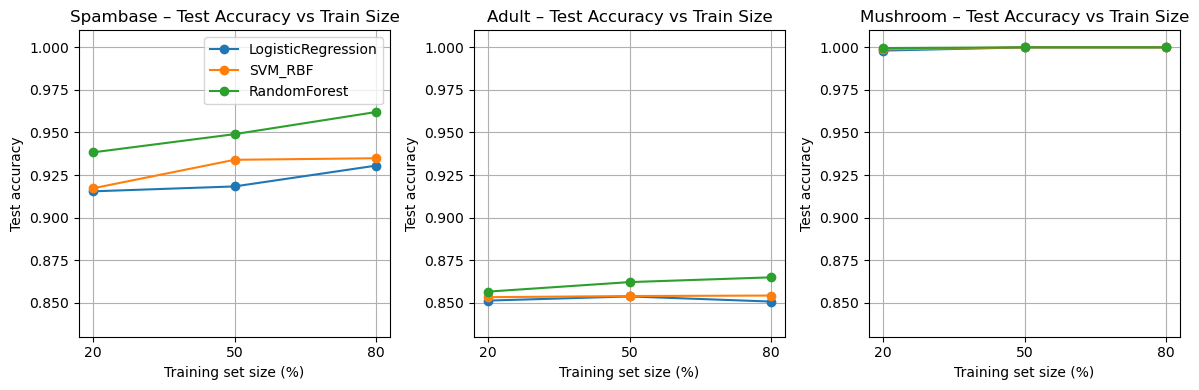

In [12]:
# Convert  to percentages
train_size_map = {0.2: 20, 0.5: 50, 0.8: 80}
plot_df = all_summaries.copy()
plot_df["train_percent"] = plot_df["train_size"].map(train_size_map)

datasets = ["Spambase", "Adult", "Mushroom"]
classifiers = ["LogisticRegression", "SVM_RBF", "RandomForest"]

plt.figure(figsize = (12, 4))

for i, ds in enumerate(datasets, 1):
    ax = plt.subplot(1, 3, i)
    ds_df = plot_df[plot_df["dataset"] == ds]
    
    for clf in classifiers:
        sub = ds_df[ds_df["classifier"] == clf].sort_values("train_percent")
        ax.plot(
            sub["train_percent"],
            sub["test_accuracy"],
            marker = "o",
            label = clf
        )
    
    ax.set_title(f"{ds} – Test Accuracy vs Train Size")
    ax.set_xlabel("Training set size (%)")
    ax.set_ylabel("Test accuracy")
    ax.set_xticks([20, 50, 80])
    ax.set_ylim(0.83, 1.01)
    ax.grid(True)
    
    if i == 1:
        ax.legend()

plt.tight_layout()
plt.show()
